# Roma Satellite Imagery Analysis with OpenEO

## Overview

This notebook demonstrates how to retrieve and visualize satellite imagery of Rome using the OpenEO API. We'll use Sentinel-2 data to create a true-color RGB image of the Rome area.

In [1]:
# Import required packages
import openeo
from openeo.processes import process

## Connect to the OpenEO Backend

We connect to the OpenEO backend service and authenticate using OpenID Connect. This establishes a connection to the remote processing service where our satellite data is stored.

In [2]:
# Connect to the back-end

# connection = openeo.connect("https://openeo.ds.io").authenticate_oidc()
connection = openeo.connect(url="http://127.0.0.1:8081/").authenticate_basic(
    username="test", password="test"
)

## Define Spatial Extent

We define the geographic boundaries of our area of interest using longitude and latitude coordinates.

In [3]:
# Rome, italy
spatial_extent_east = 12.453
spatial_extent_west = 12.283
spatial_extent_north = 41.995
spatial_extent_south = 41.890

## Load Sentinel-2 Data

We load Sentinel-2 satellite imagery for our defined area using the `load_zarr` process. 
- We select the RGB bands (B04=Red, B03=Green, B02=Blue) for true-color visualization

In [4]:
load1 = connection.datacube_from_process(
    "load_zarr",
    url="s3://esa-zarr-sentinel-explorer-fra/tests-output/sentinel-2-l2a/S2B_MSIL2A_20250921T100029_N0511_R122_T33TTG_20250921T135752.zarr",
    spatial_extent={
        "east": spatial_extent_east,
        "north": spatial_extent_north,
        "south": spatial_extent_south,
        "west": spatial_extent_west,
    },
    options={
        "variables": [
            "/measurements/reflectance/r10m:b04",
            "/measurements/reflectance/r10m:b03",
            "/measurements/reflectance/r10m:b02",
        ],
        "width": 512,
        "height": 512,
    },
)
load1

## Scale Image Values

Raw satellite reflectance values need to be scaled to standard RGB display range (0-255). We define a processing function that:
1. Scales the values from their original range (0-10000) to 0-255
2. Applies truncation to ensure all values are valid integers within range

In [5]:
def _process1(x, context=None):
    data1 = process("linear_scale_range", inputMax=1, inputMin=0, outputMax=255, x=x)
    data2 = process("trunc", x=data1)
    return data2

## Apply Processing and Enhance Visual Appearance

We apply the scaling function to our data cube, then use a color formula to enhance the visual appearance of the image. The color formula applies:
- Gamma correction (RGB 1.5) to adjust brightness and contrast
- Sigmoidal contrast enhancement (RGB 10 0.3) to improve detail visibility
- Saturation adjustment to enhance color vibrancy

In [6]:
processed = load1.apply(process=_process1)

graph = processed.process(
    "color_formula",
    data=processed,
    formula="Gamma RGB 1.5 Sigmoidal RGB 6 0.3 Saturation 1",
)
graph = graph.save_result(format="PNG")
graph

In [7]:
# Print Graph as JSON doc
print(graph.to_json())

{
  "process_graph": {
    "loadzarr1": {
      "process_id": "load_zarr",
      "arguments": {
        "options": {
          "variables": [
            "/measurements/reflectance/r10m:b04",
            "/measurements/reflectance/r10m:b03",
            "/measurements/reflectance/r10m:b02"
          ],
          "width": 512,
          "height": 512
        },
        "spatial_extent": {
          "east": 12.453,
          "north": 41.995,
          "south": 41.89,
          "west": 12.283
        },
        "url": "s3://esa-zarr-sentinel-explorer-fra/tests-output/sentinel-2-l2a/S2B_MSIL2A_20250921T100029_N0511_R122_T33TTG_20250921T135752.zarr"
      }
    },
    "apply1": {
      "process_id": "apply",
      "arguments": {
        "data": {
          "from_node": "loadzarr1"
        },
        "process": {
          "process_graph": {
            "linearscalerange1": {
              "process_id": "linear_scale_range",
              "arguments": {
                "inputMax": 1,
       

## Save and Display Result

Finally, we save the processed image as a PNG file and display it. This shows the true-color satellite view of Rome and surrounding areas.

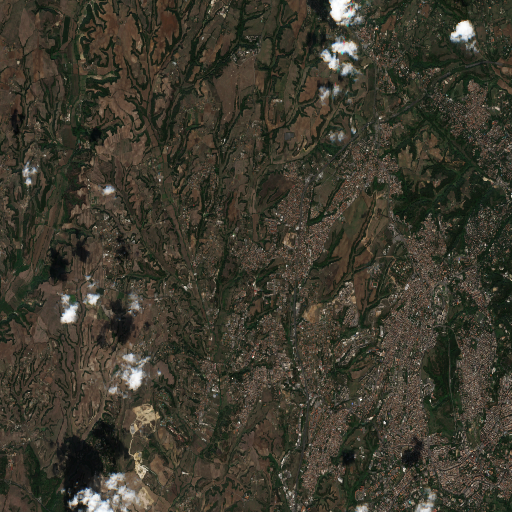

In [8]:
from IPython.display import Image

result = connection.download(graph)
Image(result)

# Print Graph as JSON doc
# print(to_geotiff.to_json())

## Or Create a XYZ Tile Service


In [9]:
# Create XYZ Service
service_extent = [12.14, 41.45, 13.10, 42.38]  # Rome

service = connection.create_service(
    graph,
    type="XYZ",
    configuration={
        "tile_size": 256,
        "minzoom": 8,
        "maxzoom": 14,
        "extent": service_extent,
    },
)

In [10]:
from folium import Map, TileLayer

m = Map(
    location=(
        (service_extent[3] + service_extent[1]) / 2,
        (service_extent[0] + service_extent[2]) / 2,
    ),
    zoom_start=8,
)

backend = "http://127.0.0.1:8081"  # OR "https://openeo.ds.io"

TileLayer(
    tiles=f"{backend}/services/xyz/{service.service_id}/tiles/{{z}}/{{x}}/{{y}}",
    opacity=1,
    attr="EOPF",
).add_to(m)
m

## Conclusion

This notebook demonstrates how to use OpenEO to access, process, and visualize satellite imagery for urban areas. The workflow can be extended to include additional analysis, such as:

- Time series analysis to observe changes over multiple dates
- Land cover classification to identify different urban features
- Spectral indices to analyze vegetation, water, or built-up areas
- Image segmentation to extract specific features